In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from skimage import color, data, restoration

%matplotlib inline

In [ ]:
from scipy.signal import convolve
from scipy.signal import fftconvolve

def richardson_lucy(image, psf, iterations=50, clip=True):
    
    #image represents the input image which is blurred and is needed to be deconvolved with the obtained filter
    #Iterations are necessary to get a close approximation
    
    direct_time = np.prod(image.shape + psf.shape)
    fft_time =  np.sum([n*np.log(n) for n in image.shape + psf.shape])
    
    ## convolution method is faster (discussed in scikit-image PR #1792)
    time_ratio = 40.032 * fft_time / direct_time
    
    if time_ratio <= 1 or len(image.shape) > 2:      # Calculate the time required to calculate convolution 
        convolve_method = fftconvolve                # and selects more faster option  
    else:
        convolve_method = convolve
    
    image = image.astype(np.float)
    psf = psf.astype(np.float)
    im_deconv = 0.5 * np.ones(image.shape)           # Defining the deconvolved matrix which would be written over 
    psf_mirror = psf[::-1, ::-1]

    for _ in range(iterations):
        relative_blur = image / convolve_method(im_deconv, psf, 'same') #
        relative_blur[np.isnan(relative_blur)] = 0       ## to prevent NaN from propogating throughout convulated matrix
        relative_blur[np.isnan(relative_blur)] = 0       ## to prevent NaN from propogating throughout convulated matrix
        im_deconv *= convolve_method(relative_blur, psf_mirror, 'same')

    if clip:
        im_deconv[im_deconv > 1] = 1
        im_deconv[im_deconv < -1] = -1
    return im_deconv

### Loading up the image

In [259]:
img_path = 'test.jpg'
img = cv2.imread(img_path, 0)

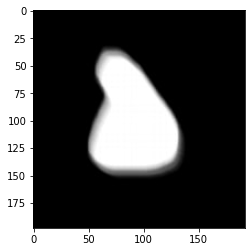

In [260]:
plt.imshow(img, cmap='gray')

In [261]:
def alphas(image):
    '''This will return the value of alphas provided the image'''
    M,N = image.shape
    alpha1 = np.zeros_like(image)
    alpha0 = np.zeros_like(image)
    threshold = image.max()
    
    for i in range(M):
        for j in range(N):
            if(image[i,j] != 0 and image[i,j] != threshold):
                alpha1[i,j] = image[i,j] # Since alpha1 is any value between 0 and threshold
            else:
                alpha0[i,j] = image[i,j] # Since alpha0 is any value in {0, threshold}
                
    
    return alpha0, alpha1

In [262]:
a0, a1 = alphas(img)

#### A0 map of the image

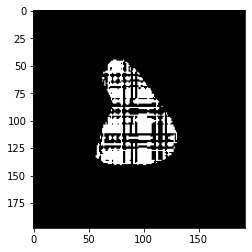

In [263]:
plt.imshow(a0, cmap='gray')

#### A1 map of the image

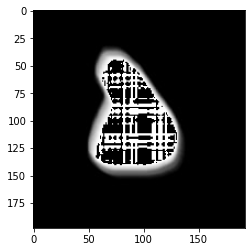

In [264]:
plt.imshow(a1, cmap='gray')

In [211]:
def filter_size(image):
    '''FINDS THE FILTER SIZE FROM THE TRANSPARANCY MAP'''
    a0 ,a1 = alphas(image)
    width, height = image.shape
    threshold = image.max()
    X1, X2 = 0,0 # X2 is right most point that has alpha value as threshold and X1 is the point with alpha value between 0 and threshold.
    Y1, Y2 = 0,0 #Y2 is the top most point that as alpha value as threshold and Y1 is the point with alpha value between 0 and threshold
    for i in range(width):
        for j in range(height):
            if(image[i,j] == threshold):
                X2 = max(X2, i)
                Y2 = max(Y2, j)
            else:
                X1 = max(X1, i)
                Y1 = max(Y1, j)
    
    width = X1 - X2 + 1
    height = Y1 - Y2 + 1
    return width, height ## X IS HEIGHT AND Y IS WIDTH SINCE ITS A COLUMN

#### We work patch wise to avoid huge computations.

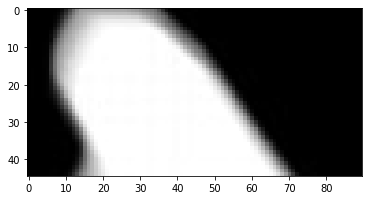

In [295]:
#Patch Selection

patches = []

patch = img[40:85, 50:140].copy() #The left wing is under this patch
patches.append(patch)

patch = img[85:145, 50:140].copy() # The right wing is under this patch
patches.append(patch)


patch = img[20:40, 45:115].copy() # The main body is under this patch
patches.append(patch)

plt.imshow(patches[0], cmap='gray')

In [296]:
#As mentioned in the paper, this method works better in small patches.
#Using the filter_size function an upper bound of the filter-size can
#be found out. 

patch = patches[0]
print(filter_size(patch), patch.shape)

(1, 26) (45, 90)


In [288]:
 

#patch = img[20: 70, 50:120]#img[45:60, 100:120]
#patch = img[20: 70, 50:120]

image = img.copy()
#image = patch.copy()#img.copy()
#filt_size = (5, 5)



filt_size = filter_size(image)#(10,10)
#filt_size = (15,15)#filter_size(image)

def loss(filt, image, summation_array):
    image = image.copy()



    a0, a1 = alphas(image)
    
    #filt.resize(filt_size)#filter_size(image))
    #filt = filt.reshape(filt_size)
    
    
    M, N = image.shape
    W, H = filt.shape

    c, d = int(W/2), int(H/2)

    a0, a1 = alphas(image)
    #a0 = a0/255
    #a1 = a1/255
    a0 = np.pad(a0, ((c, c), (d,d)))
    a1 = np.pad(a1, ((c, c), (d,d)))


    output = np.zeros_like(image, dtype=np.float64)
    for m in range(c, c+M):
        #print(m, c+M)
        for n in range(d, d+N):
            summation = 0
            for w in range(W):
                for h in range(H):
                    summation = summation + a0[m-w, n-h] * filt[w,h]  
            if(summation==0):
                summation=0.0001
            summation_array[m-c,n-d] = summation
            output[m-c,n-d] = (a1[m,n] - summation)**2
            #print( normpdf(np.abs(a1[m,n] - summation), 0, 2), "test", output[m,n])   
    output[output==0] = 0.0000001
    print(np.log(np.sum(output)))      
    return summation_array


In [289]:
foptimal = None
def grad2(filt, image, summation_array):
    global foptimal
    print(filt.shape, image.shape)
    image = image.copy()
    
    a0, a1 = alphas(image)
    
    #global a0, a1
    #filt.resize(filt_size)#filter_size(image))
    #filt = filt.reshape(filt_size)
    #print(filt.shape)
    M, N = image.shape
    W, H = filt.shape
    
    c, d = int(W/2), int(H/2)
    sigma = 2
    
    a0 = a0/255
    a1 = a1/255

    a0 = np.pad(a0, ((c, c), (d,d)))
    a1 = np.pad(a1, ((c, c), (d,d)))


    grad_helper = np.zeros_like(image, dtype=np.float64)
    grad = np.zeros_like(filt, dtype = np.float64)
    
    #print(grad.shape, grad_helper.shape, M,N, W, H)
    
    for k in range(W):
      #print(k)
      for l in range(H):
        for m in range(c, c+M):
          for n in range(d, d+N):
            #print(m-c,n-d,m,n,m-k,n-l)
            grad_helper[m-c,n-d] = - (a1[m,n] - summation_array[m-c,n-d]) * a0[m-k,n-l] 
        grad[k,l] = 2* np.sum(grad_helper)     

            
    foptimal = filt.copy()

    #plt.imshow(restoration.richardson_lucy(image, foptimal, iterations=10), cmap='gray')
    #plt.show()
    #print(filt.shape, grad.shape)

    return    grad#.reshape(-1)


#### For full image

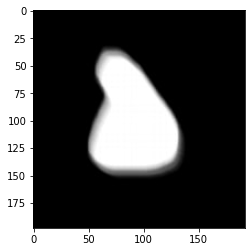

In [317]:
plt.imshow(img, cmap='gray')

(198, 193) (58, 63)
32.69159110198123
(58, 63) (198, 193)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in true_divide


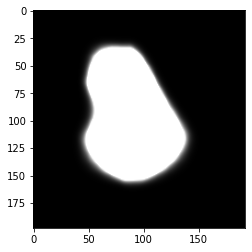

KeyboardInterrupt: ignored

In [292]:
epochs = 20
lr = 0.001
#img = patches[0].copy()
image = img.copy()
#image = alphas(image)[1]

#filt_size = (5, 5)
filt_size = filter_size(image)
print(image.shape, filt_size)

#print(filt_size)
#print(filt_size)
#f0 = np.zeros(filt_size, dtype=np.float64)
f0 = np.random.random(size=filt_size).astype(np.float64)

for i in range(epochs):

  summation_array = np.zeros_like(image, dtype = np.float64)
  summation_array = loss(f0, image, summation_array)

  gradient = grad2(f0, image, summation_array)
  f0 = f0 - (lr*gradient)#.reshape(filt_size))

  restored_image = richardson_lucy(image, foptimal, iterations=10)
  plt.imshow(restored_image, cmap='gray')
  plt.show()


  





AttributeError: ignored

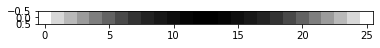

In [281]:
plt.imshow(foptimal, cmap='gray')

In [282]:
patch_out = []  #To be used later while printing output

In [ ]:
patch_out.append(restored_image)

#### Optimizing for patch 1

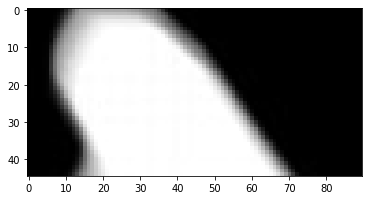

In [306]:
plt.imshow(patches[0], cmap='gray')

22.588910691620388
(1, 26) (45, 90)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in true_divide


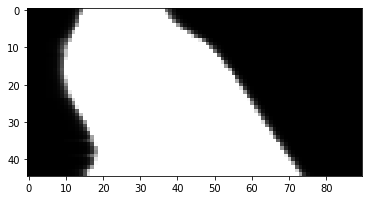

46.936462087517256
(1, 26) (45, 90)


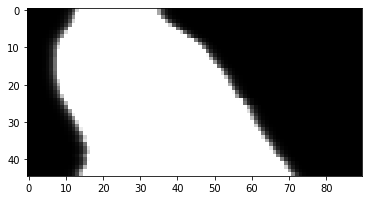

71.23187023697227
(1, 26) (45, 90)


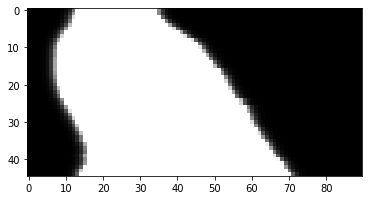

95.52748860598679
(1, 26) (45, 90)


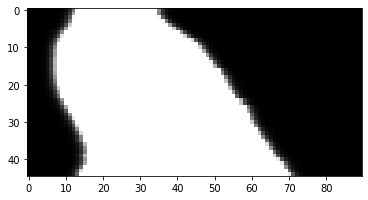

119.8231186798983
(1, 26) (45, 90)


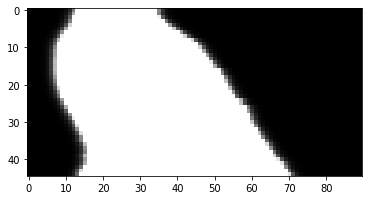

144.1187494710159
(1, 26) (45, 90)


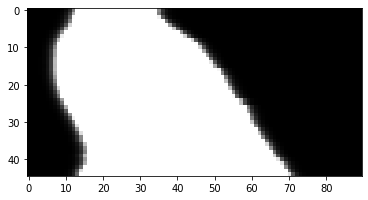

168.41438030660498
(1, 26) (45, 90)


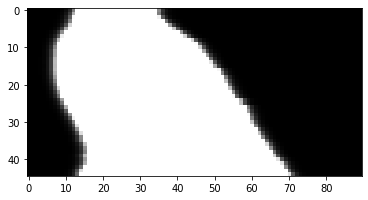

192.7100111449563
(1, 26) (45, 90)


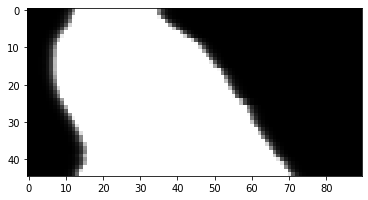

217.0056419834792
(1, 26) (45, 90)


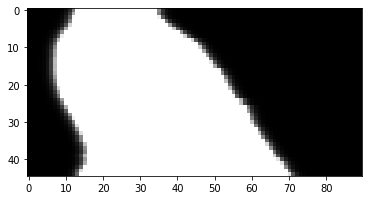

241.30127282201278
(1, 26) (45, 90)


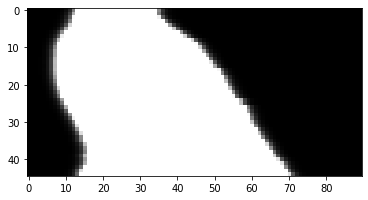

265.596903660547
(1, 26) (45, 90)


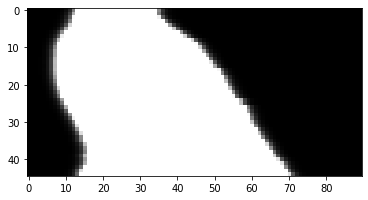

289.8925344990813
(1, 26) (45, 90)


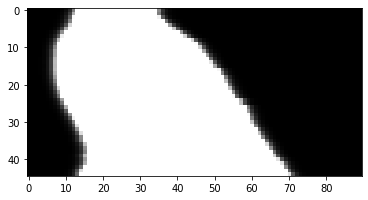

314.1881653376156
(1, 26) (45, 90)


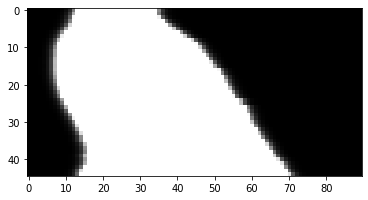

338.48379617614984
(1, 26) (45, 90)


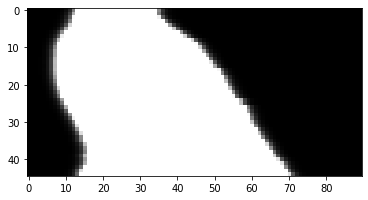

362.77942701468413
(1, 26) (45, 90)


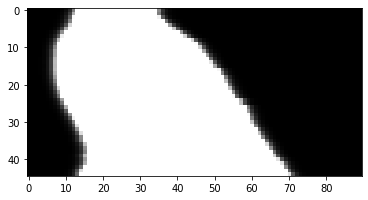

387.0750578532184
(1, 26) (45, 90)


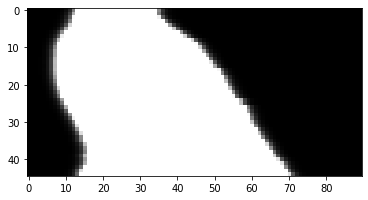

411.3706886917527
(1, 26) (45, 90)


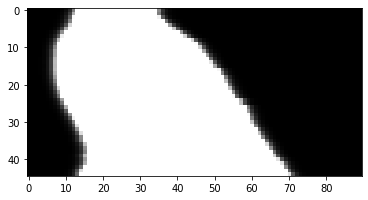

435.66631953028696
(1, 26) (45, 90)


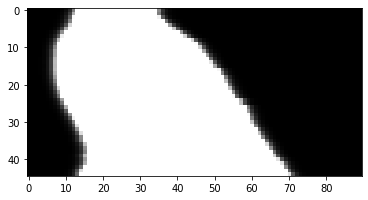

459.96195036882125
(1, 26) (45, 90)


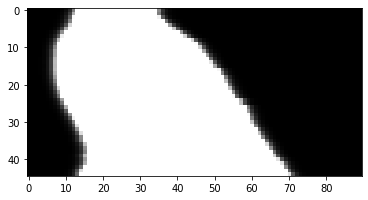

484.25758120735554
(1, 26) (45, 90)


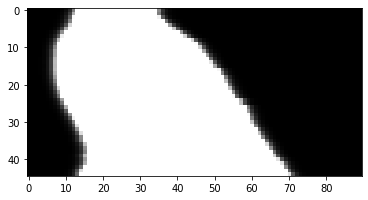

In [307]:
epochs = 20
lr = 0.03
image = patches[0].copy()

#filt_size = (10, 10)
filt_size = filter_size(patches[0])

#print(filt_size)
#print(filt_size)
#f0 = np.zeros(filt_size, dtype=np.float64)
f0 = np.random.random(size=filt_size).astype(np.float64)

for i in range(epochs):

  summation_array = np.zeros_like(image, dtype = np.float64)
  summation_array = loss(f0, image, summation_array)
  gradient = grad2(f0, image, summation_array)
  f0 = f0 - (lr*gradient)#.reshape(filt_size))
  restored_image = richardson_lucy(image, foptimal, iterations=15)
  plt.imshow(restored_image, cmap='gray')
  plt.show()


  





In [200]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


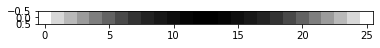

In [308]:
plt.imshow(foptimal, cmap='gray')

In [309]:
patch_out = []

In [310]:
patch_out.append(restored_image)

#### For patch 2

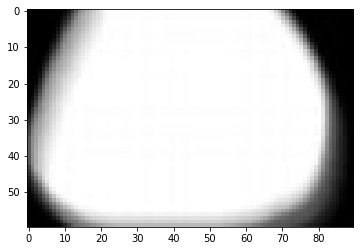

In [311]:
plt.imshow(patches[1], cmap='gray')

(5, 10)
24.506712059746427
(5, 10) (60, 90)


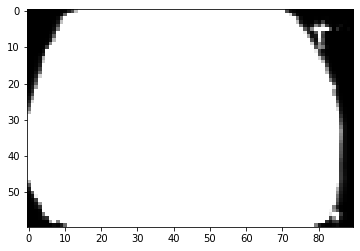

52.94183165007829
(5, 10) (60, 90)


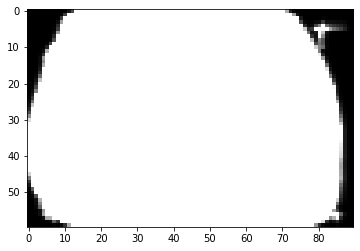

81.32924217943395
(5, 10) (60, 90)


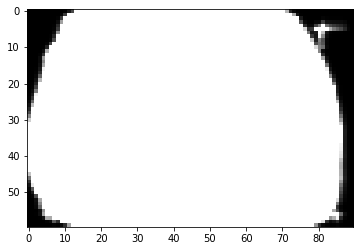

109.71666102973063
(5, 10) (60, 90)


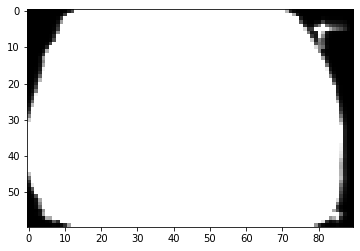

138.10407992381943
(5, 10) (60, 90)


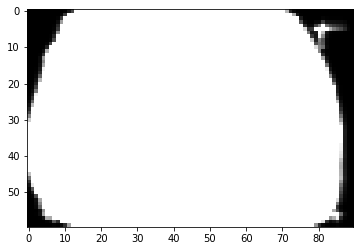

166.4914988181944
(5, 10) (60, 90)


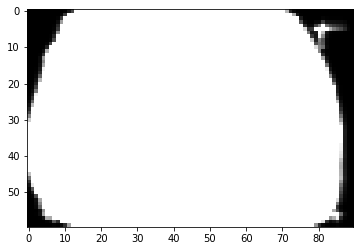

194.8789177125714
(5, 10) (60, 90)


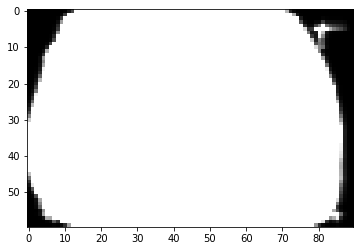

223.2663366069484
(5, 10) (60, 90)


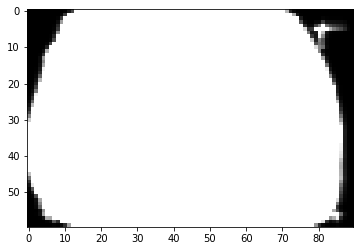

251.65375550132543
(5, 10) (60, 90)


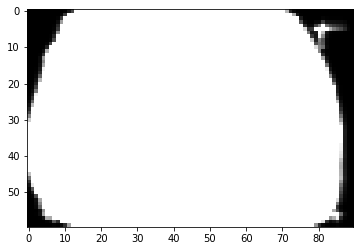

280.04117439570246
(5, 10) (60, 90)


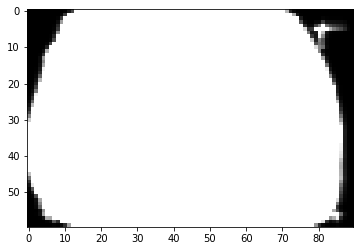

308.42859329007945
(5, 10) (60, 90)


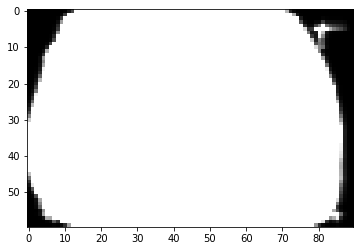

336.8160121844565
(5, 10) (60, 90)


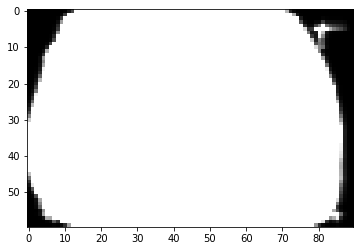

365.2034310788335
(5, 10) (60, 90)


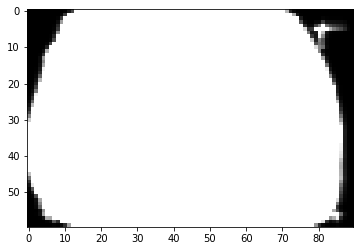

393.59084997321054
(5, 10) (60, 90)


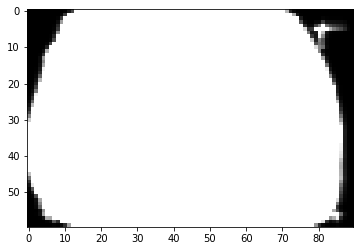

421.97826886758753
(5, 10) (60, 90)


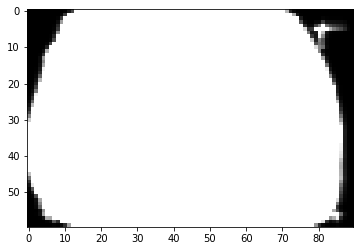

450.3656877619646
(5, 10) (60, 90)


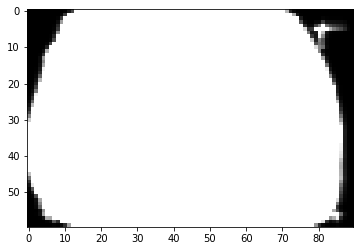

478.7531066563416
(5, 10) (60, 90)


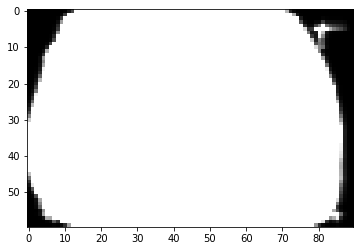

507.1405255507186
(5, 10) (60, 90)


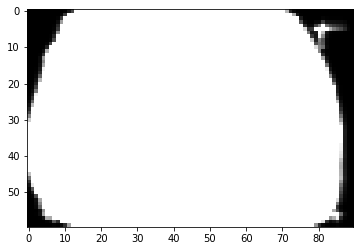

535.5279444450956
(5, 10) (60, 90)


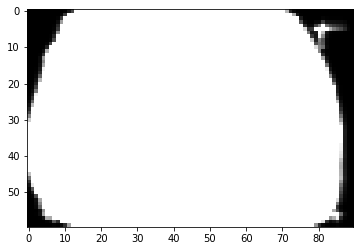

563.9153633394726
(5, 10) (60, 90)


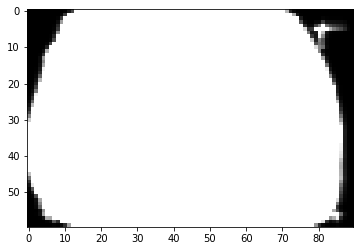

In [312]:
epochs = 20
lr = 0.05
image = patches[1].copy()
#image = alphas(image)[1]
filt_size = filter_size(image)
#filt_size = (6,8)
print(filt_size)
#print(filt_size)
#print(filt_size)
#f0 = np.zeros(filt_size, dtype=np.float64)
f0 = np.random.random(size=filt_size).astype(np.float64)

for i in range(epochs):

  summation_array = np.zeros_like(image, dtype = np.float64)
  summation_array = loss(f0, image, summation_array)
  gradient = grad2(f0, image, summation_array)
  f0 = f0 - (lr*gradient)#.reshape(filt_size))
  restored_image = richardson_lucy(image, foptimal, iterations=10)
  plt.imshow(restored_image, cmap='gray')
  plt.show()

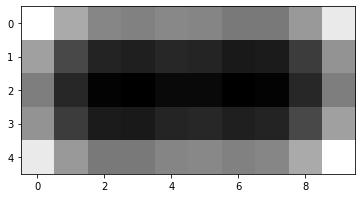

In [313]:
plt.imshow(foptimal, cmap='gray')

In [314]:
patch_out.append(restored_image)

#### Patch Stiching

In [ ]:
# Now we aggregate all the outputs from patch and form our image

In [ ]:
#patch = img[40:85, 50:140].copy() #The left wing is under this patch
#patches.append(patch)

#patch = img[85:145, 50:140].copy() # The right wing is under this patch
#patches.append(patch)


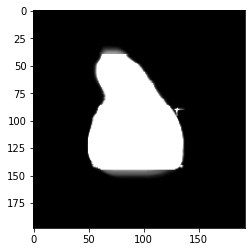

In [315]:
test = img.copy()
test[40:85, 50:140] = patch_out[0] * 255

test[85:145, 50:140] = patch_out[1] * 255




plt.imshow(test, cmap='gray')

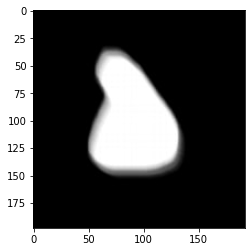

In [316]:
plt.imshow(img, cmap='gray')

As we can see from this example that the algorithm works much more efficiently on patches than the full image. Hence, we only use patches. 